<a href="https://colab.research.google.com/github/Kihann/small_project/blob/main/AIB_CA_%EC%9D%B4%EA%B8%B0%ED%95%9C_small_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AI Bootcamp / SECTION 4*

---

# Small Project 2. Attention & Transformer

## 🏆 학습 목표

- Atenttion Mechanism의 탄생 배경과 연산 과정에 대해 설명할 수 있다.
- Transformer의 구조에 대해 이해하고 설명할 수 있다.
  - 기존 RNN 기반의 언어 모델과 비교했을 때, Transformer가 가지고 있는 장점에 대해 설명할 수 있다.
  - Transformer의 main idea인 Self-attention Mechanism에 대해 이해하고 설명할 수 있다.
  - Transformer의 전체적인 구조를 이해하고 이를 이용해 코드로 구현할 수 있다.

## 🛫 Warm up

RNN이 갖고 있는 단점에 대해 기억하시나요? 🤔
- 장기 의존성(Long-term Dependency) 문제
- 병렬화 불가

<br>이번 노트에서는 기계 번역(Machine Translation)을 위한 **Seq2Seq** 모델부터 RNN의 단점으로 발생한 한계점을 보완한 **Attention Mechanism**,  
그리고 Attention Mechanism을 극대화하여 번역 성능을 극대화한 **Transformer**까지 알아볼 것입니다.  

<br>딥러닝에 대해 학습할 때는 Task 해결을 위해 처음에 어떤 모델이 제안되고, 이후에 어떤 단점이 나타나고,  
그 단점은 어떤 방법을 이용해 해결되었는지 시간의 흐름대로 학습해가는 것이 중요합니다.  
여러분도 시간의 흐름대로 정리해가며 학습해보시는 것을 추천드립니다! 💪

## 🙇 들어가기 전에!

이번 노트에서는 자연어 처리를 위해 제안된 매커니즘과 이를 활용한 대표적인 모델에 대해 다루고 있습니다.  
아래의 내용에 대해 선행 지식이 부족하다면 본 노트를 이해하기 어려울 수 있습니다.
- 인공 신경망에 대한 기본 개념 및 용어
- 자연어 처리(Natural Language Processing, NLP)에 대한 기본 개념 및 용어
- 벡터화(Vectorization) & 워드 임베딩(Word Embedding)
- 순환 신경망(Recurrent Neural Network, RNN)의 구조 및 장단점

## ***1. Attention Mechanism***

---


### **Attention Mechanism의 등장 배경**

#### **시퀀스-투-시퀀스 (Sequence-to-Sequence, Seq2Seq)**

Attention에 대해서 알아보기 위해 먼저 Seq2Seq에 대해서 간단하게 살펴보겠습니다.  

<br>Seq2Seq는 RNN을 기반으로 한 언어 모델(Language Model)이며, 시퀀스를 입력하고 원하는 출력 시퀀스를 만들어내는 모델입니다.  
그리고 기계 번역(Machine Translation)을 구현하기 위해 만들어진 대표적인 모델입니다.

<br>아래 이미지는 불어를 영어로 번역하는 상황이라 가정하고 Seq2Seq 모델의 세부 구조를 도식화한 이미지입니다.

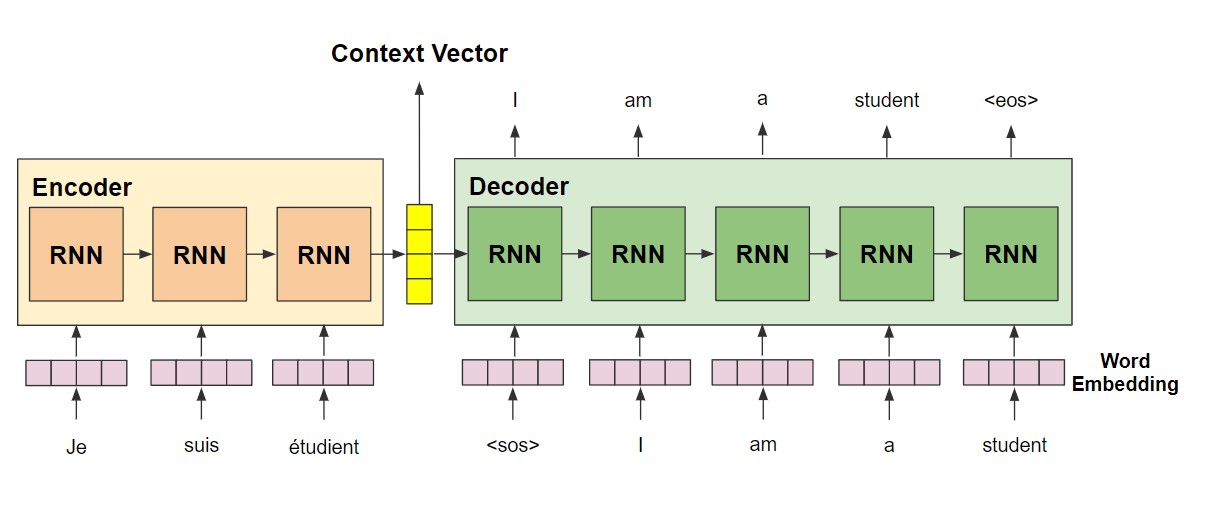

seq2seq는 크게 **인코더(Encoder)**와 **디코더(Decoder)**라 불리는 두 개의 스테이지로 구성됩니다.

<br>입력될 텍스트는 모두 토큰화한 후, **<font color='magenta'>임베딩 벡터</font>**로 만들어져 입력되게 됩니다.  
인코더와 디코더 안에 각각의 RNN 셀은 우리가 배운 Vanilla RNN부터 LSTM, GRU까지 순환 신경망이라면 어떤 것이든 적용 가능합니다.

<br>먼저, 인코더에서는 데이터(**번역할 문장**의 모든 단어)를 순차적으로 입력받고, 마지막에 이 모든 단어 정보들을 압축해서 하나의 벡터로 만듭니다.  
이를 **<font color='DAA520'>컨텍스트 벡터(Context Vector) 혹은 문맥 벡터</font>**라고 합니다.

그 다음, 디코더에서는 인코더로부터 전달받은 컨텍스트 벡터와 번역된 문장을 이용해 **번역된 단어**를 한 개씩 순차적으로 출력합니다.  
이 때, 디코더의 input과 output의 각각 앞, 뒤에 ```<sos>```와 ```<eos>``` 토큰을 이용해 문장의 시작과 끝을 알려줍니다.

번역된 문장을 입력 데이터로 받는다니, 무언가 이상하다 생각하실 수 있습니다.  
Seq2Seq는 훈련 과정과 실제 추론 과정(또는 테스트 과정)에서 작동 방식이 기존에 우리가 배웠던 딥러닝 모델과는 조금 다릅니다.  
훈련 과정에서 정답을 알려주면서 학습을 진행하게 됩니다. 이를 **교사 강요(Teacher Forcing)**이라고 합니다.  

이렇게 학습을 진행하는 이유는 예측하고자 하는 시점 이전의 디코더 셀이 만들어낸 예측이 틀렸는데, 예측 시점에서 이를 그대로 사용하면 예측이 굉장히 어렵고 학습이 더디게 진행되게 됩니다. 이러한 문제를 방지하기 위해 훈련 과정에선 정답을 알려주며 학습을 진행하게 됩니다.  

<br>이외에도 성능 향상을 위해 인코더에서 입력 시퀀스를 거꾸로 뒤집어 학습하는 등 부가적인 내용이 있습니다.  
하지만 부가적인 내용이니 이 정도만 알아보고 넘어가보도록 하겠습니다.

> ❓ *입력 시퀀스의 순서를 거꾸로 뒤집으면 왜 성능이 향상될까요?*

#### **Seq2Seq의 한계**

Seq2Seq는 RNN 기반의 모델입니다.  
RNN 기반의 모델이기 때문에 발생하는 단점이 있는데요. 이 단점은 **<font color='DAA520'>context vector</font>**에서 발생하게 됩니다.  

<br>앞서 살펴본 바와 같이 **크기가 고정된 하나의 벡터에 모든 단어 정보들을 압축**하기 때문에 정보 손실이 발생하게 됩니다.  
이를 **장기 의존성(Long-term Dependency) 문제**라고도 합니다.
LSTM이나 GRU와 같이 보다 발전된 RNN을 이용해도 한정된 공간에 모든 정보를 담아내야 하기 때문에 시퀀스의 길이가 길어지면 앞선 단어에 대한 정보가 희미해지고, 이는 번역 성능이 크게 저하되는 문제를 일으키게 됩니다. 

<br>입력 시퀀스가 길어지면 출력 시퀀스의 정확도가 떨어지는 것을 보정해주기 위해 Attention이란 기법이 등장하게 됩니다.

### **Attention Mechanism이란?**

Attention은 매 시점에서의 디코더의 출력 단어마다 인코더에 입력된 전체 문장을 다시 한 번 참고합니다.  
이 때, 문장의 전체 단어를 전부 같은 비율로 참고하는 것이 아니라, 그 시점에서 예측해야할 단어와 연관이 있는 입력 단어에 더 **집중(attention)**해서 참고하기 때문에 **Attention**이란 이름으로 명명되었습니다!

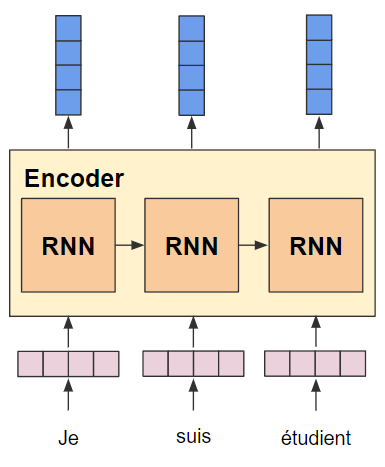

지난 노트에서 RNN은 **<font color='4682D4'>연산 결과</font>**를 출력하며 동시에 다음 시점(time step)의 RNN 셀에 그 결과를 넘겨주던 것을 기억하시나요?  
기존의 Seq2Seq는 가장 마지막 시점에서의 인코더의 연산값, 즉, **<font color='DAA520'>context vector</font>**만 디코더에서 이용하는데 어텐션은 각 시점마다 생성되는 **<font color='4682D4'>은닉 벡터(Hidden-state Vector)</font>**를 모두 이용하겠다는 의미입니다.

<br>그럼 계속해서 이 벡터들을 어떻게 이용하는지 계속해서 살펴보겠습니다!

#### **Query, Key, Value**

앞서 이야기한 **<font color='4682D4'>은닉 벡터(hidden-state vector)</font>**를 어떻게 이용한다는 걸까요?

<br>바로 Query와 Key, Value로써 이용합니다.  
> ❗ *Query, Key, Value를 이용한 아이디어는 Transformer에서도 계속됩니다! 이를 꼭 이해하고 가는 것을 추천드립니다!*

- **Query**는 '질문(하다)'라는 사전적 의미를 가지고 있습니다. 즉, 어떤 질문을 하겠다는 의미로 볼 수 있습니다.
- **Key, Value**는 우리가 사용하고 있는 파이썬 언어의 딕셔너리 자료형과 유사하다 볼 수 있습니다.  
Key를 이용해 Value를 호출하는 한 쌍의 구조를 가지고 있습니다.


<br> 이를 정리하면 다음과 같습니다.
- **Query** 번역할 문장과의 관계를 알고자하는 hidden-state vector, **'예측 시점에서의 디코더의 은닉 벡터'**
- **Key**는 Query와 어떤 관계가 있는지 살펴볼 때 이용할 hidden-state vector, **'모든 시점의 인코더의 은닉 벡터'**
- **Value**는 Query와 Key를 통해 나온 결과가 반영되는 hidden-state vector, **'모든 시점의 인코더의 은닉 벡터'**

<br> 예를 들어 'student'라는 단어를 번역할 시점이라면 아래의 이미지와 같이  
**Query**는 **<font color='DC143C'>디코더에서 해당 시점에 생성된 은닉 벡터</font>**, **Key**와 **Value**는 각각 **<font color='4682D4'>인코더에서 모든 시점에 생성된 은닉 벡터</font>**가 되는 것입니다.

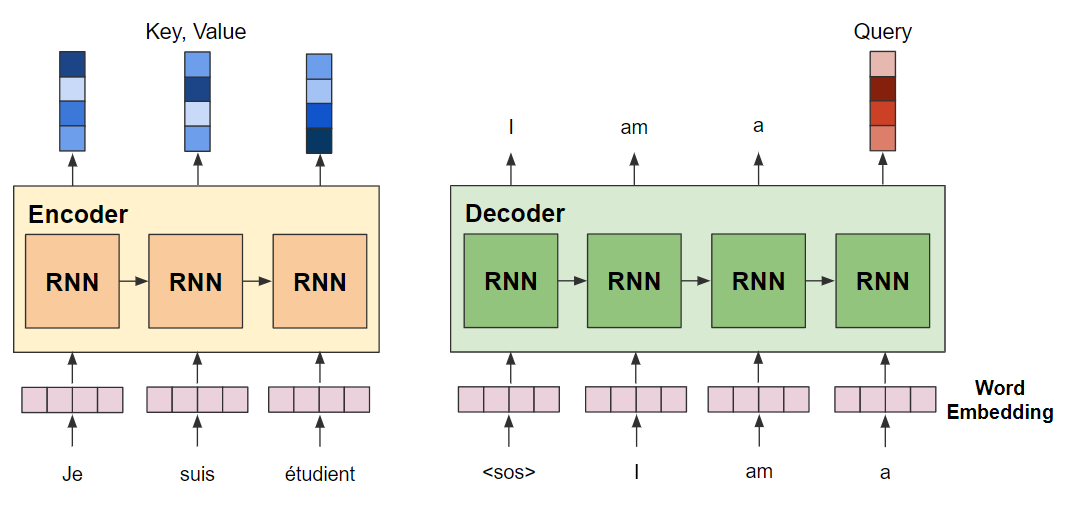

#### **Attention Mechanism의 연산 과정**

필요한 재료는 모두 마련되었습니다. 이제부터 어떻게 연산이 되는지 살펴보겠습니다.  

<br>아래는 Dot-Product Attention에 연산 과정을 담고 있습니다.  
사실 다양한 종류의 어텐션이 존재하지만, 연산 과정이 가장 단순한 Dot-Product Attention을 통해 어텐션에 대해 알아보겠습니다.  
다른 어텐션과의 차이는 대게 연산 중에 사소한 차이가 존재하며 이외 나머지는 대부분 유사합니다.

1. **Query 벡터와 각각의 Key 벡터를 내적합니다.**  
  각 벡터간 유사도를 구하기위한 과정이며, 이 내적한 값들을 어텐션 스코어(Attention Score)라고도 부릅니다.  
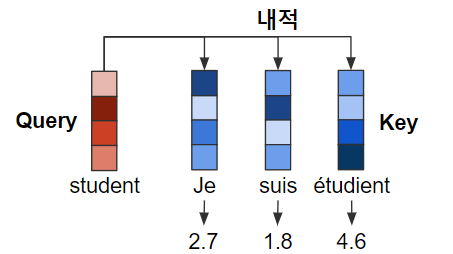


2. **어텐션 스코어에 소프트맥스(Softmax) 함수를 취해줍니다.**  
  이 때, 소프트맥스를 취한 결과값을 어텐션 분포(Attention Distribution)라고도 부릅니다.  
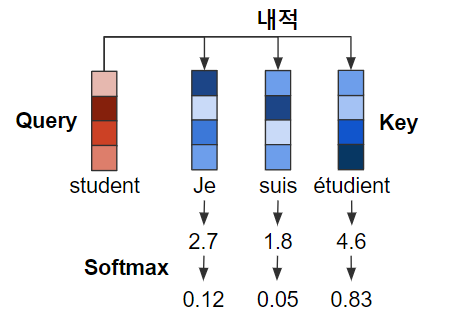  


3. **어텐션 분포와 Value 벡터를 각각 곱하고 더해줍니다(=가중합).**  
  이 때, 이 결과값을 어텐션 값(Attention Value) 혹은 입력 시퀀스의 문맥을 담고 있어 앞서 Seq2Seq처럼 **문맥 벡터(Context Vector)**라고 부르며, 우리가 최종적으로 얻고자 하는 벡터입니다.  
입력 시퀀스에 각 단어(토큰)의 정보를 내적을 통해 구해진 유사도만큼만 반영하며 Seq2Seq의 **<font color='DAA520'>context vector</font>**와 이름은 같지만 값은 다른 모습을 보이고 있습니다.  
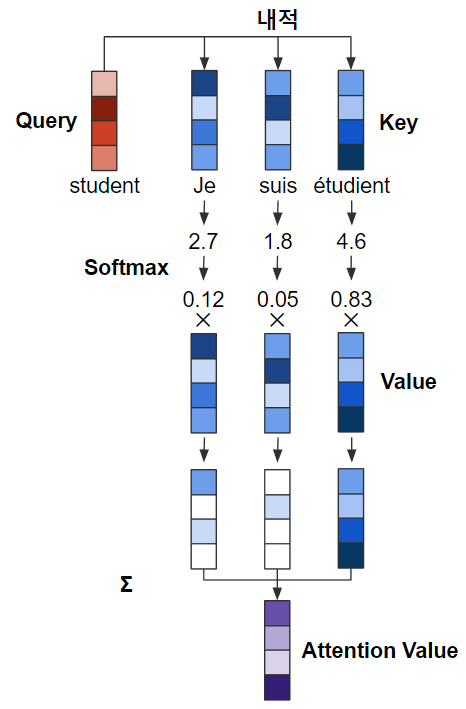

> ❓ *왜 어텐션 스코어를 바로 이용하지 않고 Softmax를 취해준 다음에 가중합을 진행할까요?*

이후에는 추가적인 몇 가지 작업을 더해 모델을 완성하게 됩니다.  
- 우선 어텐션 값을 이용하기 위해 **<font color='DC143C'>디코더의 은닉 벡터(쿼리)</font>**와 **이어붙여(Concat)**줍니다.  
이어붙여 만들어진 새로운 벡터는 디코더에서의 정보를 담고 있음과 동시에 인코더의 정보를 개별적으로 반영한 새로운 벡터가 됩니다.  
- 논문에서는 이 벡터를 출력층으로 바로 보내지 않고, 가중치 연산을 한 번 더 진행하고 활성화 함수로 tanh를 취해줍니다.  
- 그 다음 softmax 함수를 취해 최종적으로 어떤 단어가 올지 결정하게 됩니다.


### **Seq2Seq with Attention 코드 실습**

## ***2. Transformer(Attention Is All You Need)***

---

여러분은 트랜스포머(Transformer)하면 무엇이 떠오르나요? 변신 로봇? 변압기?  
**트랜스포머(Transformer)**는 2017년 구글에서 발표한 [Attention is All You Need](https://arxiv.org/abs/1706.03762)라는 논문에서 제안된 모델입니다.  

<br>논문의 제목에서 알 수 있듯 **Attention**에만 주목하여 모델을 구축했는데요. RNN을 사용하지 않으면서 어떤 일이 일어났을까요?

**RNN은** 데이터를 순차적으로 처리하는 그 구조상 **병렬화가 어렵다**는 단점이 있던 것을 기억하시나요?  
근본적으로 RNN을 사용하지 않아 기존 RNN 기반의 언어 모델이 갖고 있던 병렬화가 불가하다는 단점을 극복했습니다.  
병렬화가 가능하다는 말은 GPU를 이용한 연산에도 최적화되어 있단 말이겠죠?  

병렬 연산에도 최적화되어 있는데, 인코더-디코더의 구조와 Attention 매커니즘만 사용해 구조가 상대적으로 단순합니다.  
병렬화로 처리 속도가 빠른데 성능은 우수해 최근에는 컴퓨터 비전, 정형 데이터 처리같은 다른 Task에서도 사용 시도가 이루어지고 있습니다.  
Attention is All You Need 논문은 현재 50,000번 넘게 인용되었습니다. 정말 다양한 방면으로 응용되고 있다는 말이겠죠? 

<br>**참고 기사**
- [네이버, '초거대 AI 하이퍼클로바' 일상 서비스 곳곳 접목](https://biz.newdaily.co.kr/site/data/html/2022/06/13/2022061300060.html)
- [엔비디아, 아스트라제네카와 AI 연구 프로젝트 진행](https://www.epnc.co.kr/news/articleView.html?idxno=205933)  
- [오픈AI, 앤드류 응도 놀란 DALL·E 공개...GPT-3 원리로 획기적인 이미지 제작 혁신](http://www.aitimes.com/news/articleView.html?idxno=135460)

<br>트랜스포머와 관련된 기사를 몇 개 가져와 보았습니다.  
자연어 처리 뿐만 아니라, 화학 분야에서도, 이미지 생성에서도 트랜스포머가 이용되고 있는 모습을 볼 수 있습니다.  
바야흐로 트랜스포머의 시대에 살고 있다고해도 과언이 아닌데요. 알아보지 않을 수가 없겠죠?  
논문에서 제안한 트랜스포머 그대로 가장 기본적인 구조로 차근차근 알아보도록 하겠습니다.

### **Transformer의 구조**

아래는 트랜스포머 모델의 전체 모양을 간단히 도식화한 이미지입니다.  
기존 Seq2Seq의 Encoder-Decoder 구조를 사용하는데요. 차이점은 인코더와 디코더를 여러 개 사용한다는 것입니다.  
이때 각각의 박스로 표현된 인코더, 디코더를 '블록'이라 부릅니다.

인코더와 디코더 블록을 겹겹이 쌓아 성능을 높여주는데요. 논문에서는 각 블록을 6개씩 사용하였습니다.

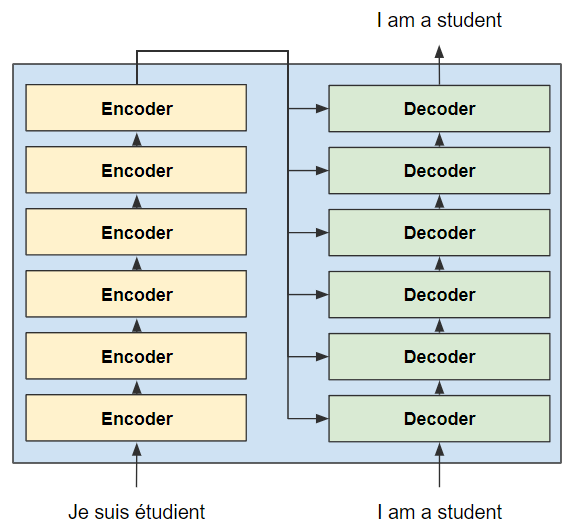

아래의 이미지에서 모델의 구조에 대해 조금 더 자세히 살펴볼까요?

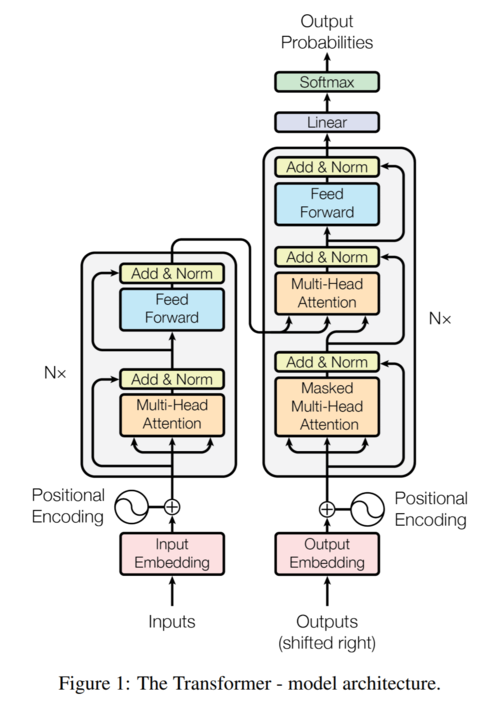

조금 더 자세히 살펴보니 구조가 굉장히 복잡해 보입니다.  
하지만 여러분들이 이전에 학습했던 내용들이 포함되어 있기 때문에 몇 가지만 더 살펴보면 됩니다.

1. Positional Encoding
2. Multi-Head Attention
3. Add & Norm
4. Masked Multi-Head Attention

이외에는 위에 나열한 내용들에 대해 알아가면서 같이 살펴보며 넘어가겠습니다!

#### **1. Positional Encoding**

#### **2. Multi-Head Attention**

#### **3. Add & Norm**

#### **4. Masked Multi-Head Attention**

###**Transformer 코드 실습**

## 마치며..

##Reference
---